In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
from functools import reduce
from sklearn.preprocessing import StandardScaler

import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, log_loss
from scipy.stats import ks_2samp

import time

In [2]:
acctDF = pd.read_parquet('../../data/q2-ucsd-acctDF.pqt')
acctDF['balance_date'] = pd.to_datetime(acctDF['balance_date'])

consDF_all = pd.read_parquet('../../data/q2-ucsd-consDF.pqt')

consDF = consDF_all.dropna()
trxnDF = pd.read_parquet('../../data/q2-ucsd-trxnDF.pqt')
trxnDF['posted_date'] = pd.to_datetime(trxnDF['posted_date'])

cat_map = pd.read_csv('../../data/q2-ucsd-cat-map.csv')
cat_map = dict(zip(cat_map['category_id'], cat_map['category']))

trxnDF.category = trxnDF.category.replace(cat_map)

In [3]:
check_acct_totals = acctDF[acctDF.account_type == 'CHECKING'].groupby(['prism_consumer_id', 'balance_date']).sum()
check_acct_totals = check_acct_totals.reset_index()
check_acct_totals = check_acct_totals.drop(axis=1,labels='prism_account_id')
check_acct_totals.head()

,prism_consumer_id,balance_date,account_type,balance
0,0,2021-08-31,CHECKING,294.6700
1,1,2021-06-30,CHECKING,91.2400
2,10,2022-01-31,CHECKING,822.7500
3,100,2021-04-30,CHECKING,802.4000
4,1000,2023-01-31,CHECKING,95.2300


In [4]:
def calc_balances_all(check_acct_totals, trxnDF):
    # Merge transactions with account balances
    merged = trxnDF.merge(
        check_acct_totals[['prism_consumer_id', 'balance_date', 'balance']], 
        on='prism_consumer_id', how='left'
    )

    # Identify pre and post transactions
    merged['is_pre'] = merged['posted_date'] <= merged['balance_date']

    # Set adjustment values based on pre/post period
    merged['adjustment'] = 0.0
    merged.loc[merged['is_pre'] & (merged['credit_or_debit'] == 'CREDIT'), 'adjustment'] = -merged['amount']
    merged.loc[merged['is_pre'] & (merged['credit_or_debit'] == 'DEBIT'), 'adjustment'] = merged['amount']
    merged.loc[~merged['is_pre'] & (merged['credit_or_debit'] == 'CREDIT'), 'adjustment'] = merged['amount']
    merged.loc[~merged['is_pre'] & (merged['credit_or_debit'] == 'DEBIT'), 'adjustment'] = -merged['amount']

    # Pre-balance transactions: Sort descending and apply reverse cumsum
    pre_trans = merged[merged['is_pre']].sort_values(by=['prism_consumer_id', 'posted_date'], ascending=[True, False])
    pre_trans['curr_balance'] = pre_trans.groupby('prism_consumer_id')['adjustment'].cumsum() + pre_trans.groupby('prism_consumer_id')['balance'].transform('first')

    # Post-balance transactions: Sort ascending and apply forward cumsum
    post_trans = merged[~merged['is_pre']].sort_values(by=['prism_consumer_id', 'posted_date'], ascending=[True, True])
    post_trans['curr_balance'] = post_trans.groupby('prism_consumer_id')['adjustment'].cumsum() + post_trans.groupby('prism_consumer_id')['balance'].transform('first')

    # Combine results
    result = pd.concat([pre_trans, post_trans]).sort_values(by=['prism_consumer_id', 'posted_date'])

    return result[['prism_consumer_id', 'prism_transaction_id', 'category', 'amount', 'credit_or_debit', 'posted_date', 'curr_balance']].sort_values(by='posted_date', ascending=False)



In [5]:
balanceDF = calc_balances_all(check_acct_totals, trxnDF)
# balanceDF['category'] = balanceDF.category.apply(lambda x: cat_map[x])

In [6]:
# cat_dict = cat_map.set_index('category_id')['category'].to_dict()
# balanceDF['cat_name'] = balanceDF.category.apply(lambda x: cat_dict[x])

balanceDF.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance
2518565,8144,2486689,PAYCHECK,95.1300,CREDIT,2024-05-06,-66.3800
2518585,8144,2486709,AUTOMOTIVE,4.0400,DEBIT,2024-05-06,87.6600
2518578,8144,2486702,EXTERNAL_TRANSFER,150.0000,DEBIT,2024-05-06,83.6200
2518582,8144,2486706,AUTOMOTIVE,12.3200,DEBIT,2024-05-03,117.7600
2518568,8144,2486692,ATM_CASH,83.0000,DEBIT,2024-05-03,105.4400


In [7]:
trxnDF

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,MISCELLANEOUS,0.0500,CREDIT,2021-04-16
1,3023,1,LOAN,481.5600,CREDIT,2021-04-30
2,3023,2,MISCELLANEOUS,0.0500,CREDIT,2021-05-16
3,3023,3,MISCELLANEOUS,0.0700,CREDIT,2021-06-16
4,3023,4,MISCELLANEOUS,0.0600,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,BILLS_UTILITIES,4.9600,DEBIT,2022-03-11
6407317,10533,6405305,LOAN,63.4800,DEBIT,2022-03-30
6407318,10533,6405306,LOAN,53.9900,DEBIT,2022-03-30
6407319,10533,6405307,LOAN,175.9800,DEBIT,2022-03-31


### Feature Gen

In [8]:
# cat_mappings = dict(zip(cat_map['category_id'], cat_map['category']))
# trxcat_mappings = dict(zip(cat_map['category_id'], cat_map['category']))
# trxnDF['category_id'] = trxnDF.category
# trxnDF.category = trxnDF.category.replace(cat_mappings)

In [9]:
def filter_time_window(df, days=None, months=None, years=None):
    def filter_group(group):
        latest_date = group['posted_date'].max()  # Get latest transaction date per consumer
        cutoff_date = latest_date - pd.DateOffset(days=days or 0, months=months or 0, years=years or 0)
        return group[group['posted_date'] >= cutoff_date]  # Filter transactions

    return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)

In [10]:
def compute_balance_delta(balance_filtered, label):
    # Get last balance per consumer
    last_balance = balance_filtered.groupby('prism_consumer_id')['curr_balance'].last().reset_index()
    last_balance = last_balance.rename(columns={'curr_balance': 'curr_balance_last'})
    
    # Get earliest balance in the filtered dataset
    first_balance = balance_filtered.groupby('prism_consumer_id')['curr_balance'].first().reset_index()
    first_balance = first_balance.rename(columns={'curr_balance': 'curr_balance_first'})
    
    # Merge and compute balance delta
    df_merged = last_balance.merge(first_balance, on='prism_consumer_id', how='left')
    df_merged[f'balance_delta_{label}'] = df_merged['curr_balance_last'] - df_merged['curr_balance_first']
    
    # Keep only relevant columns
    return df_merged[['prism_consumer_id', f'balance_delta_{label}']]


In [11]:
def generate_category_features(trxnDF, cat_map, categories):
    """
    Generates transaction-based features for each selected category over multiple time windows.
    
    Parameters:
        trxnDF (pd.DataFrame): DataFrame containing transaction data.
        cat_map (pd.DataFrame): DataFrame mapping category IDs to category names.
        categories (str or list): One or more transaction categories to filter.

    Returns:
        pd.DataFrame: Aggregated features per prism_consumer_id.
    """
    if isinstance(categories, str):
        categories = [categories]

    # trxnDF = trxnDF.merge(cat_map, left_on='category', right_on='category_id', how='left')
    # trxnDF['category'] = trxnDF['category_y']
    # trxnDF = trxnDF.drop(columns=['category_id', 'category_y'])

    trxnDF['posted_date'] = pd.to_datetime(trxnDF['posted_date'])

    time_windows = {
        'overall': None,
        'last_14_days': 14,
        'last_30_days': 30,
        'last_3_months': 90,
        'last_6_months': 180,
        'last_year': 365
    }

    features_dict = {}

    for category in categories:
        # filter transactions for the current category
        filtered_trxn = trxnDF[trxnDF['category'] == category].copy()

        # get last posted date per consumer
        last_posted_dates = filtered_trxn.groupby('prism_consumer_id')['posted_date'].max()

        for window_name, days in time_windows.items():
            if days is None:
                df_time_filtered = filtered_trxn
            else:
                # consumer-specific time filters
                df_time_filtered = filtered_trxn.merge(last_posted_dates, on='prism_consumer_id', suffixes=('', '_latest'))
                df_time_filtered = df_time_filtered[df_time_filtered['posted_date'] >= (df_time_filtered['posted_date_latest'] - pd.Timedelta(days=days))]
                df_time_filtered = df_time_filtered.drop(columns=['posted_date_latest'])

            # aggregate features
            agg_features = df_time_filtered.groupby('prism_consumer_id')['amount'].agg(
                mean='mean',
                median='median',
                std='std',
                max='max',
                min='min',
                count='count',
                sum='sum'
            )

            # total transaction count per consumer in the time window
            total_trxn_counts = trxnDF.groupby('prism_consumer_id')['amount'].count()

            # compute percentage of transactions in this category for the time window
            percentage_trxn = (agg_features['count'] / total_trxn_counts).fillna(0)
            percentage_trxn = percentage_trxn.rename(f"{category}_{window_name}_percent")

            agg_features = agg_features.rename(columns=lambda x: f"{category}_{window_name}_{x}")

            features_dict[f"{category}_{window_name}"] = pd.concat([agg_features, percentage_trxn], axis=1)


    final_features = pd.concat(features_dict.values(), axis=1).fillna(0)
    return final_features


In [12]:
def compute_threshold_stats(df, thresholds, cat_label):
    # Count total gambling transactions
    counts = df.groupby('prism_consumer_id').size().reset_index(name=f'{cat_label}_count')

    # Check thresholds
    threshold_flags = df.groupby('prism_consumer_id')['amount'].agg(lambda x: [any(x >= t) for t in thresholds]).apply(pd.Series)
    threshold_flags.columns = [f'{cat_label}_over_{t}' for t in thresholds]
    threshold_flags = threshold_flags.astype(bool)  # Convert to True/False

    # Merge counts and flags
    result = counts.merge(threshold_flags, on='prism_consumer_id', how='left')

    return result


In [13]:
# creating relevant outflows df with only expenses
debits_not_expenses = ['SELF_TRANSFER', 'ATM_CASH']
credits_not_income = ['SELF_TRANSFER', 'LOAN', 'REFUND'] # maybe TAX

outflows_agg_df = trxnDF[(trxnDF.credit_or_debit == 'DEBIT') & (~trxnDF['category'].isin(debits_not_expenses))] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
outflows_agg_df.columns = ['outflows_amt_' + col for col in outflows_agg_df.columns]

inflows_agg_df = trxnDF[(trxnDF.credit_or_debit == 'CREDIT') & (~trxnDF['category'].isin(credits_not_income))] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
inflows_agg_df.columns = ['inflows_amt_' + col for col in inflows_agg_df.columns]

In [14]:
%%time

balance_ftrs = balanceDF.groupby('prism_consumer_id')['curr_balance'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
balance_ftrs.columns = ['balance_' + x for x in balance_ftrs.columns]
balance_last_14_days = filter_time_window(balanceDF, days=14)
balance_last_30_days = filter_time_window(balanceDF, days=30)
balance_last_3_months = filter_time_window(balanceDF, months=1)
balance_last_6_months = filter_time_window(balanceDF, months=6)
balance_last_year = filter_time_window(balanceDF, years=1)

balance_last_14_days_metrics = balance_last_14_days.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
balance_last_14_days_metrics.columns = ['balance_last_14_days_' + x for x in balance_last_14_days_metrics.columns]

balance_last_30_days_metrics = balance_last_30_days.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
balance_last_30_days_metrics.columns = ['balance_last_30_days_' + x for x in balance_last_30_days_metrics.columns]

balance_last_3_months_metrics = balance_last_3_months.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
balance_last_3_months_metrics.columns = ['balance_last_3_months_' + x for x in balance_last_3_months_metrics.columns]

balance_last_6_months_metrics = balance_last_6_months.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
balance_last_6_months_metrics.columns = ['balance_last_6_months_' + x for x in balance_last_6_months_metrics.columns]

balance_last_year_metrics = balance_last_year.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
balance_last_year_metrics.columns = ['balance_last_1_year_' + x for x in balance_last_year_metrics.columns]

balance_dfs = [consDF[['prism_consumer_id']], balance_ftrs, balance_last_14_days_metrics, balance_last_30_days_metrics, balance_last_3_months_metrics, balance_last_6_months_metrics, balance_last_year_metrics]
balance_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id', how='left'), balance_dfs)

balance_ftrs.shape

/tmp/ipykernel_400/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_400/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_400/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on t

CPU times: user 46.7 s, sys: 2.92 s, total: 49.6 s
Wall time: 49.7 s


(12000, 37)

In [15]:
%%time

# balance_deltas
balance_delta_overall = compute_balance_delta(balanceDF, 'overall')
balance_delta_14d = compute_balance_delta(balance_last_14_days, '14d')
balance_delta_30d = compute_balance_delta(balance_last_30_days, '30d')
balance_delta_3m = compute_balance_delta(balance_last_3_months, '3m')
balance_delta_6m = compute_balance_delta(balance_last_6_months, '6m')
balance_delta_1y = compute_balance_delta(balance_last_year, '1y')


balance_deltas_dfs = [consDF[['prism_consumer_id']], balance_delta_overall, balance_delta_14d, balance_delta_30d, balance_delta_3m, balance_delta_6m, balance_delta_1y]
balance_deltas_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id', how='left'), balance_deltas_dfs)



CPU times: user 1.78 s, sys: 296 ms, total: 2.07 s
Wall time: 2.07 s


In [16]:
trxn_df_last_14_days = filter_time_window(trxnDF, days=14)
trxn_df_last_30_days = filter_time_window(trxnDF, days=30)
trxn_df_last_3_months = filter_time_window(trxnDF, months=3)
trxn_df_last_6_months = filter_time_window(trxnDF, months=6)
trxn_df_last_year = filter_time_window(trxnDF, years=1)

debits_df = trxnDF[trxnDF.credit_or_debit == 'DEBIT']
credits_df = trxnDF[trxnDF.credit_or_debit == 'CREDIT']

debits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'DEBIT']
debits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'DEBIT']
debits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'DEBIT']
debits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'DEBIT']
debits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'DEBIT']

credits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'CREDIT']
credits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'CREDIT']
credits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'CREDIT']
credits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'CREDIT']
credits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'CREDIT']

/tmp/ipykernel_400/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_400/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_400/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on t

In [17]:
%%time

# creating windowed expenses aggregate metrics
outflows_ftrs = debits_df[~debits_df['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
outflows_ftrs.columns = ['outflows_amt_' + col for col in outflows_ftrs.columns]

outflows_last_14_days_agg_df = debits_df_last_14_days[~debits_df_last_14_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
outflows_last_14_days_agg_df.columns = ['outflows_amt_last_14_days_' + col for col in outflows_last_14_days_agg_df.columns]

outflows_last_30_days_agg_df = debits_df_last_30_days[~debits_df_last_30_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
outflows_last_30_days_agg_df.columns = ['outflows_amt_last_30_days_' + col for col in outflows_last_30_days_agg_df.columns]

outflows_last_3_months_agg_df = debits_df_last_3_months[~debits_df_last_3_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
outflows_last_3_months_agg_df.columns = ['outflows_amt_last_3_months_' + col for col in outflows_last_3_months_agg_df.columns]

outflows_last_6_months_agg_df = debits_df_last_6_months[~debits_df_last_6_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
outflows_last_6_months_agg_df.columns = ['outflows_amt_last_6_months_' + col for col in outflows_last_6_months_agg_df.columns]

outflows_last_year_agg_df = debits_df_last_year[~debits_df_last_year['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
outflows_last_year_agg_df.columns = ['outflows_amt_last_year_' + col for col in outflows_last_year_agg_df.columns]

outflows_df = [consDF[['prism_consumer_id']], outflows_ftrs, outflows_last_14_days_agg_df, outflows_last_30_days_agg_df, outflows_last_3_months_agg_df, outflows_last_6_months_agg_df, outflows_last_year_agg_df]
outflows_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id', how='left'), outflows_df)

# inflows
inflows_ftrs = credits_df[~credits_df['category'].isin(credits_not_income)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
inflows_ftrs.columns = ['outflows_amt_' + col for col in inflows_ftrs.columns]

inflows_last_14_days_agg_df = credits_df_last_14_days[~credits_df_last_14_days['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
inflows_last_14_days_agg_df.columns = ['inflows_amt_last_14_days_' + col for col in inflows_last_14_days_agg_df.columns]

inflows_last_30_days_agg_df = credits_df_last_30_days[~credits_df_last_30_days['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
inflows_last_30_days_agg_df.columns = ['inflows_amt_last_30_days_' + col for col in inflows_last_30_days_agg_df.columns]

inflows_last_3_months_agg_df = credits_df_last_3_months[~credits_df_last_3_months['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
inflows_last_3_months_agg_df.columns = ['inflows_amt_last_3_months_' + col for col in inflows_last_3_months_agg_df.columns]

inflows_last_6_months_agg_df = credits_df_last_6_months[~credits_df_last_6_months['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
inflows_last_6_months_agg_df.columns = ['inflows_amt_last_6_months_' + col for col in inflows_last_6_months_agg_df.columns]

inflows_last_year_agg_df = credits_df_last_year[~credits_df_last_year['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
inflows_last_year_agg_df.columns = ['inflows_amt_last_year_' + col for col in inflows_last_year_agg_df.columns]

inflows_df = [consDF[['prism_consumer_id']], inflows_ftrs, inflows_last_14_days_agg_df, inflows_last_30_days_agg_df, inflows_last_3_months_agg_df, inflows_last_6_months_agg_df, inflows_last_year_agg_df]
inflows_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id', how='left'), inflows_df)

outflows_ftrs.shape, inflows_ftrs.shape

CPU times: user 3.73 s, sys: 364 ms, total: 4.1 s
Wall time: 4.09 s


((12000, 37), (12000, 37))

In [18]:
# cat_map.category.unique()

cat_ok = ['SELF_TRANSFER', 'EXTERNAL_TRANSFER', 'DEPOSIT', 'PAYCHECK',
       'MISCELLANEOUS', 'PAYCHECK_PLACEHOLDER', 'REFUND',
       'INVESTMENT_INCOME', 'OTHER_BENEFITS', 
       'SMALL_DOLLAR_ADVANCE', 'TAX', 'LOAN', 'INSURANCE',
       'FOOD_AND_BEVERAGES', 'UNCATEGORIZED', 'GENERAL_MERCHANDISE',
       'AUTOMOTIVE', 'GROCERIES', 'ATM_CASH', 'ENTERTAINMENT', 'TRAVEL',
       'ESSENTIAL_SERVICES', 'ACCOUNT_FEES', 'HOME_IMPROVEMENT',
       'OVERDRAFT', 'CREDIT_CARD_PAYMENT', 'HEALTHCARE_MEDICAL', 'PETS',
       'EDUCATION', 'GIFTS_DONATIONS', 'BILLS_UTILITIES', 'MORTGAGE',
       'RENT', 'BNPL', 'AUTO_LOAN',
       'BANKING_CATCH_ALL', 'DEBT', 'FITNESS', 'TRANSPORATION', 'LEGAL',
       'GOVERNMENT_SERVICES', 'RISK_CATCH_ALL', 'RTO_LTO', 'INVESTMENT',
       'GAMBLING', 'CORPORATE_PAYMENTS', 'TIME_OR_STUFF', 'PENSION']

In [19]:
%%time

category_features = generate_category_features(trxnDF, cat_map, cat_ok)
category_features.shape

CPU times: user 1min 37s, sys: 14.5 s, total: 1min 52s
Wall time: 1min 52s


(14492, 2304)

In [20]:
%%time

gambling_df_all = balanceDF[balanceDF['category'] == 'GAMBLING']
gambling_thresholds = [50, 100, 500, 1000]

# Filter for different time periods
gambling_last_month = filter_time_window(gambling_df_all, months=1)
gambling_last_6m = filter_time_window(gambling_df_all, months=6)
gambling_last_year = filter_time_window(gambling_df_all, years=1)

gambling_stats_all = compute_threshold_stats(gambling_df_all, gambling_thresholds, 'all')
gambling_stats_month = compute_threshold_stats(gambling_last_month, gambling_thresholds, '1m')
gambling_stats_6m = compute_threshold_stats(gambling_last_6m, gambling_thresholds, '6m')
gambling_stats_year = compute_threshold_stats(gambling_last_year, gambling_thresholds, '1y')

gambling_df = [consDF[['prism_consumer_id']], gambling_stats_all, gambling_stats_month, gambling_stats_6m, gambling_stats_year]
gambling_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id', how='left'), gambling_df)

gambling_ftrs.shape

/tmp/ipykernel_400/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_400/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_400/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on t

CPU times: user 4.12 s, sys: 67.4 ms, total: 4.19 s
Wall time: 4.18 s


(12000, 21)

In [21]:
feature_dfs = [consDF[['prism_consumer_id', 'DQ_TARGET']], balance_ftrs, balance_deltas_ftrs, category_features, outflows_ftrs, inflows_ftrs, inflows_agg_df, outflows_agg_df, gambling_ftrs,]
features_all = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id', how='left'), feature_dfs)
cs_ftrs = pd.merge(features_all, consDF[['prism_consumer_id', 'credit_score']], on='prism_consumer_id', how='left')
features_all.shape

(12000, 2452)

## Model Training

In [22]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier # pip install
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier # pip install

import matplotlib.pyplot as plt
import seaborn as sns

### Check to include scoring exclusions

In [23]:
trxn_counts = trxnDF.groupby('prism_consumer_id')['prism_transaction_id'].count()
cons_at_least_2_trxns = set(trxn_counts[trxn_counts >= 2].index)

balance_sum = acctDF.groupby('prism_consumer_id')['balance'].sum()
cons_non_zero_balances = set(balance_sum[balance_sum != 0].index)

credit_debit_counts = trxnDF.groupby('prism_consumer_id')['credit_or_debit'].value_counts().unstack(fill_value=0)
credit_debit_counts.columns = ['num_credits', 'num_debits']
cons_non_zero_credits = set(credit_debit_counts[credit_debit_counts.num_credits > 0].index)
cons_non_zero_debits = set(credit_debit_counts[credit_debit_counts.num_debits > 0].index)
cons_has_both_credits_debits = set(credit_debit_counts[((credit_debit_counts.num_credits > 0) & (credit_debit_counts.num_debits > 0))].index)

In [24]:
kept_cons = cons_at_least_2_trxns & cons_non_zero_balances & cons_has_both_credits_debits

In [25]:
features_cons_kept = features_all[features_all.prism_consumer_id.isin(kept_cons)]
cs_ftrs = cs_ftrs[cs_ftrs.prism_consumer_id.isin(kept_cons)]

In [133]:
# data = features_all.copy().drop(labels='prism_consumer_id', axis=1)                ## catboost 0.767, light / hist ~0.75

########### CHOOSE WITH CREDIT SCORE OR WITHOUT ###########
# data = features_cons_kept.copy().drop(labels='prism_consumer_id', axis=1)
data = cs_ftrs.copy().drop(labels='prism_consumer_id', axis=1)

binary_cols = [col for col in data.columns if data[col].nunique() == 2 and sorted(data[col].unique()) == [0, 1]]
continuous_cols = [col for col in data.columns if col not in binary_cols]

scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])


print(data.shape)
data.head()

(9825, 2452)


,DQ_TARGET,balance_mean,balance_std,balance_median,balance_min,balance_max,balance_sum,balance_last_14_days_mean,balance_last_14_days_std,balance_last_14_days_median,...,6m_over_50,6m_over_100,6m_over_500,6m_over_1000,1y_count,1y_over_50,1y_over_100,1y_over_500,1y_over_1000,credit_score
0,0.0000,-0.0898,-0.1871,-0.0821,0.1067,-0.1815,-0.0673,-0.0481,-0.0564,-0.0255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8250
1,0.0000,-0.2186,-0.1621,-0.1917,-0.0472,-0.2508,-0.1249,-0.0390,-0.0525,-0.0182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4429
2,0.0000,-0.0680,-0.0366,-0.1200,0.0437,-0.1205,-0.0519,-0.0388,-0.0268,-0.0241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2418
3,0.0000,-0.2302,-0.0873,-0.2005,-0.2681,-0.2097,-0.1254,-0.0424,-0.0481,-0.0243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9264
4,0.0000,-0.0648,-0.2182,-0.0475,0.1123,-0.1947,-0.0661,-0.0424,-0.0573,-0.0246,...,0.8035,1.0151,-0.4198,-0.2525,-0.2119,0.8035,1.0132,-0.4213,-0.2525,0.1910


In [138]:
data_orig = data.copy()
data_orig[continuous_cols] = scaler.inverse_transform(data[continuous_cols])
data_orig.fillna(0, inplace=True)


In [139]:
### WILL NEED BETTER FIX THAN THIS ###

data.fillna(0, inplace=True)

In [66]:
def fit_model(X_train, y_train, model_type='log_reg'):
    """
    Fits a machine learning model based on the specified type.
    """

    ###############################
    ## MODEL TRAIN BY MODEL TYPE ##
    ###############################
    start = time.time()
    if model_type == 'log_reg':
        model = LogisticRegression(max_iter=1000, n_jobs=-1).fit(X_train, y_train) # TODO: hyperparameter config

    finish = time.time()
    training_time = finish-start
    print(f'Training Time = {training_time:.4f} seconds')
    return model

def predict(X, y, model, le=None):
    """
    Makes predictions using the trained model and evaluates accuracy.
    """
    preds = model.predict(X)
    try: 
        preds_proba = model.predict_proba(X)
        return preds, preds_proba[:, 1]
    except:
        return preds

def proba(X, y, model, le=None):
    """
    Returns probability DQ_TARGET=1 using the trained model and evaluates accuracy.
    """
    preds_proba = model.predict_proba(X)
    return preds_proba[:, 1]

def evaluate_model(y, y_pred, y_pred_proba):
    # train metrics
    roc_auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    return {'Accuracy': accuracy, 'ROC_AUC': roc_auc}

def pipeline(X, y, model_type='log_reg'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    model = fit_model(X_train, y_train, model_type)
    y_train_pred, y_train_prob = predict(X_train, y_train, model)
    y_test_pred, y_test_prob = predict(X_test, y_test, model)

    print("##### TRAIN METRICS #####")
    train_metrics = evaluate_model(y_train, y_train_pred, y_train_prob)
    print("##### TEST METRICS #####")
    test_metrics = evaluate_model(y_test, y_test_pred, y_test_prob)
    
    return  train_metrics, test_metrics

In [32]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_type, model=None):
    """Trains and evaluates the specified model."""
    models = {
        "HistGB": HistGradientBoostingClassifier(),
        "CatBoost": CatBoostClassifier(verbose=0),
        "LightGBM": LGBMClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "LogisticRegression": LogisticRegression()
    }
    
    if model_type not in models:
        raise ValueError(f"Unsupported model type: {model_type}. Choose from {list(models.keys())}")

    if model == None:
        model = models[model_type]

    # Train model and track training time
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    print(f"Training Time: {end - start:.4f} seconds")

    # Predictions
    start_pred = time.time()
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    end_pred = time.time()

    print(f"Prediction Time: {end_pred - start_pred:.4f} seconds")


    # Evaluation Metrics
    metrics = {
        "ROC_AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    # Print Metrics
    print(f'{model_type} metrics:')
    for metric, value in metrics.items():
        print(f"\t{metric}: {value}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({model_type})")
    plt.show()

    return model, metrics


In [33]:
X = data.drop(columns=["DQ_TARGET"])
y = data['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,)

In [34]:
data.shape

(9825, 2452)

#### SMOTE Data

In [35]:
# !pip install imbalanced-learn

In [36]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter
from collections import defaultdict
import pandas as pd

In [37]:
from sklearn.metrics import roc_curve, auc

In [38]:
orig_count = Counter(y_train)
print("Original class distribution:", orig_count, 
      "Percent DQ:", f"{100 * orig_count[1.0] / (orig_count[1.0] + orig_count[0.0]):.2f}%")

Original class distribution: Counter({0.0: 6723, 1.0: 645}) Percent DQ: 8.75%


In [39]:
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# data_smote = pd.DataFrame(X_resampled, columns=X.columns)
# data_smote['target_column'] = y_resampled

# Check class counts
count_0, count_1 = y_train.value_counts()[0], y_train.value_counts()[1]
new_0 = int(0.8 * count_0)  # Target count for balancing
new_1 = int(2.5* count_1)

# Ensure SMOTE does not create more than the original number of samples
smote = SMOTE(sampling_strategy={1: new_1},)

# Undersampling the majority class to match the new minority class count
under = RandomUnderSampler(sampling_strategy={0: new_0},)

# Combine SMOTE & Undersampling in a pipeline
resample_pipeline = Pipeline(steps=[('smote', smote), ('under', under)])

# Apply resampling
X_resampled, y_resampled = resample_pipeline.fit_resample(X_train, y_train)

In [40]:
end_count = Counter(y_resampled)
print("Original class distribution:", end_count, 
      "Percent DQ:", f"{100 * end_count[1.0] / (end_count[1.0] + end_count[0.0]):.2f}%")

Original class distribution: Counter({0.0: 5378, 1.0: 1612}) Percent DQ: 23.06%


In [41]:
X_train, X_validation, y_train, y_validation = train_test_split(X_resampled, y_resampled, test_size=0.25,)

In [42]:
lr = fit_model(X_train, y_train, 'log_reg')
y_train_pred, y_train_prob = predict(X_train, y_train, lr)
y_validation_pred, y_validation_prob = predict(X_validation, y_validation, lr)
y_test_pred, y_test_prob = predict(X_test, y_test, lr)

Training Time = 4.7820 seconds


In [43]:
lr_train_metrics = evaluate_model(y_train, y_train_pred, y_train_prob)

ROC AUC Score: 0.9770
Accuracy: 0.9340

Confusion Matrix:
[[3897  148]
 [ 198  999]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96      4045
         1.0       0.87      0.83      0.85      1197

    accuracy                           0.93      5242
   macro avg       0.91      0.90      0.90      5242
weighted avg       0.93      0.93      0.93      5242



In [44]:
lr_validation_metrics = evaluate_model(y_validation, y_validation_pred, y_validation_prob)

ROC AUC Score: 0.8738
Accuracy: 0.8278

Confusion Matrix:
[[1160  173]
 [ 128  287]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89      1333
         1.0       0.62      0.69      0.66       415

    accuracy                           0.83      1748
   macro avg       0.76      0.78      0.77      1748
weighted avg       0.83      0.83      0.83      1748



In [45]:
lr_test_metrics = evaluate_model(y_test, y_test_pred, y_test_prob)

ROC AUC Score: 0.6999
Accuracy: 0.8335

Confusion Matrix:
[[1975  285]
 [ 124   73]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.87      0.91      2260
         1.0       0.20      0.37      0.26       197

    accuracy                           0.83      2457
   macro avg       0.57      0.62      0.58      2457
weighted avg       0.88      0.83      0.85      2457



### Feature Selection (L1 Lasso)

In [46]:
from sklearn.feature_selection import SelectFromModel, RFE

In [47]:
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1) # can test different Cs
model_l1.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [48]:
# selector = SelectFromModel(model_l1, prefit=True, threshold=-np.inf, max_features=50)
# top_50 = list(X_train.columns[selector.get_support()])
# selector = SelectFromModel(model_l1, prefit=True, threshold=-np.inf, max_features=100)
# top_100 = list(X_train.columns[selector.get_support()])
# selector = SelectFromModel(model_l1, prefit=True, threshold=-np.inf, max_features=200)
# top_200 = list(X_train.columns[selector.get_support()])
# selector = SelectFromModel(model_l1, prefit=True, threshold=-np.inf, max_features=500)
# top_500 = list(X_train.columns[selector.get_support()])
# X_50_train = X_train[top_50]
# X_50_validation = X_validation[top_50]
# X_50_test = X_test[top_50]
# X_100_train = X_train[top_100]
# X_100_validation = X_validation[top_100]
# X_100_test = X_test[top_100]
# X_200_train = X_train[top_200]
# X_200_validation = X_validation[top_200]
# X_200_test = X_test[top_200]
# X_500_train = X_train[top_500]
# X_500_validation = X_validation[top_500]
# X_500_test = X_test[top_500]

In [50]:
importances = np.abs(model_l1.coef_).flatten()

# Create a DataFrame with feature names and importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)  # Sort by importance in descending order

# Function to select top N features
def select_top_n_features(n):
    return feature_importance_df.iloc[:n]['Feature'].tolist()

# Select top features based on sorted importance
top_50 = select_top_n_features(50)
top_100 = select_top_n_features(100)
top_200 = select_top_n_features(200)
top_500 = select_top_n_features(500)
top_650 = select_top_n_features(650)
top_1000 = select_top_n_features(1000)

# Subset the datasets using the sorted top features
X_50_train, X_50_validation, X_50_test = X_train[top_50], X_validation[top_50], X_test[top_50]
X_100_train, X_100_validation, X_100_test = X_train[top_100], X_validation[top_100], X_test[top_100]
X_200_train, X_200_validation, X_200_test = X_train[top_200], X_validation[top_200], X_test[top_200]
X_500_train, X_500_validation, X_500_test = X_train[top_500], X_validation[top_500], X_test[top_500]

In [51]:
categories = trxnDF.category.unique()

In [52]:
# top_500

In [53]:
with open('500_ftrs.txt', 'w') as f:
    for x in top_500:
        f.write(x + '\n')

In [54]:
extra_50 = X_train.columns[~X_train.columns.isin(top_50)].tolist()
extra_100 = X_train.columns[~X_train.columns.isin(top_100)].tolist()
extra_200 = X_train.columns[~X_train.columns.isin(top_200)].tolist()
extra_500 = X_train.columns[~X_train.columns.isin(top_500)].tolist()

In [55]:
def limit_category_features(top_features, extra_features, max_per_category=2):
    category_map = defaultdict(list)
    
    # Step 1: Group features by category
    for feature in top_features:
        temp = feature.split("_")[0]
        if '_'.join([temp[0], temp[1]]) in categories:
            category = '_'.join([temp[0], temp[1]])
        else:
            category = temp[0]
            
        
        category_map[category].append(feature)

    # Step 2: Keep only `max_per_category` per category
    filtered_features = []
    for category, features in category_map.items():
        filtered_features.extend(features[:max_per_category])

    # Step 3: Fill removed spots with extra features
    needed = len(top_features) - len(filtered_features)
    extra_index = 0
    while needed > 0 and extra_index < len(extra_features):
        new_feature = extra_features[extra_index]
        new_category = new_feature.split("_")[0]

        # Ensure the replacement does not exceed the category limit
        if sum(1 for f in filtered_features if f.startswith(new_category)) < max_per_category:
            filtered_features.append(new_feature)
            needed -= 1
        
        extra_index += 1
    
    return filtered_features


In [56]:
new_50 = limit_category_features(top_50, extra_50, 2)
new_100 = limit_category_features(top_100, extra_100, 2)
new_200 = limit_category_features(top_200, extra_200, 3) # note, 200 ftrs allows for 3 of the same ftr
new_500 = limit_category_features(top_500, extra_500, 10) 

Training Time: 31.6621 seconds
Prediction Time: 0.2987 seconds
CatBoost metrics:
	ROC_AUC: 0.8088518036027134
	Accuracy: 0.9124949124949125
	Precision: 0.37142857142857144
	Recall: 0.1319796954314721
	F1-Score: 0.1947565543071161
	Confusion Matrix: [[2216   44]
 [ 171   26]]


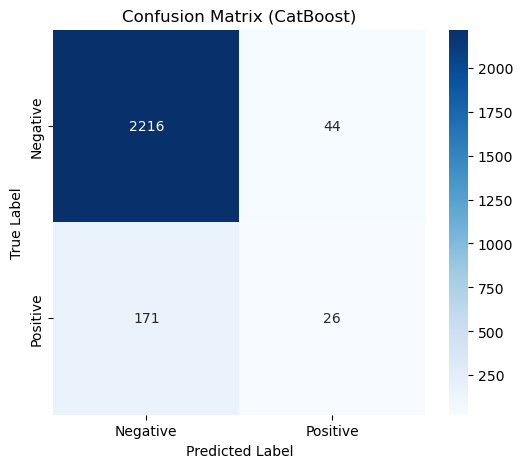

In [63]:
model, results = train_and_evaluate(X_train[top_1000], y_train, X_test[top_1000], y_test, model_type="CatBoost")

In [57]:
# model, results = train_and_evaluate(X_200_train, y_train, X_200_validation, y_validation, model_type="LogisticRegression")

In [58]:
# model, results = train_and_evaluate(X_200_train, y_train, X_200_test, y_test, model_type="LogisticRegression")

In [59]:
# model, results = train_and_evaluate(X_100_train, y_train, X_100_validation, y_validation, model_type="HistGB")

Training Time: 22.0473 seconds
Prediction Time: 0.0495 seconds
CatBoost metrics:
	ROC_AUC: 0.8129239477112439
	Accuracy: 0.9153439153439153
	Precision: 0.4225352112676056
	Recall: 0.15228426395939088
	F1-Score: 0.22388059701492538
	Confusion Matrix: [[2219   41]
 [ 167   30]]


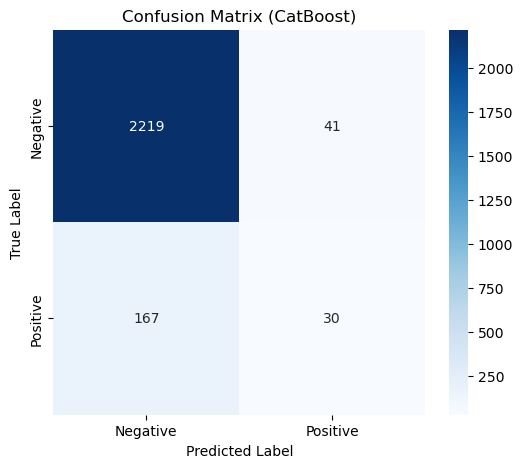

In [60]:
model, results = train_and_evaluate(X_train[top_650], y_train, X_test[top_650], y_test, model_type="CatBoost")

Training Time: 18.2958 seconds
Prediction Time: 0.0371 seconds
CatBoost metrics:
	ROC_AUC: 0.8131013880778041
	Accuracy: 0.9153439153439153
	Precision: 0.4266666666666667
	Recall: 0.16243654822335024
	F1-Score: 0.23529411764705882
	Confusion Matrix: [[2217   43]
 [ 165   32]]


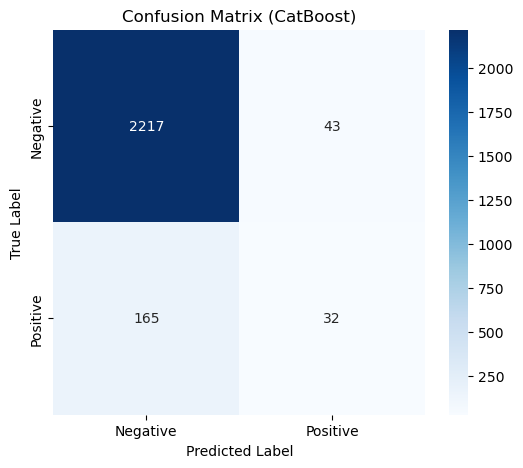

In [61]:
model, results = train_and_evaluate(X_train[top_500], y_train, X_test[top_500], y_test, model_type="CatBoost")

Training Time: 32.0230 seconds
Prediction Time: 0.0635 seconds
CatBoost metrics:
	ROC_AUC: 0.8141904568843189
	Accuracy: 0.9153439153439153
	Precision: 0.4875
	Recall: 0.18932038834951456
	F1-Score: 0.2727272727272727
	Confusion Matrix: [[2210   41]
 [ 167   39]]


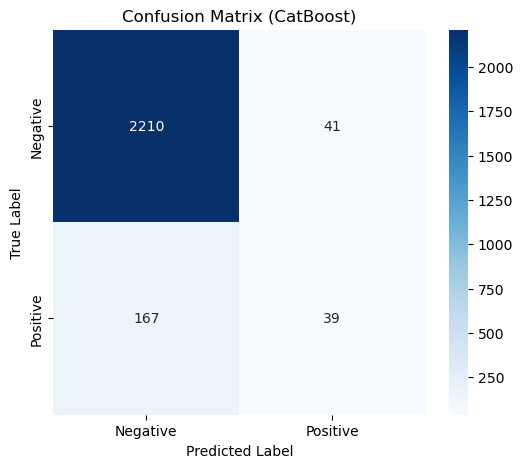

In [167]:
model, results = train_and_evaluate(X_train[top_1000], y_train, X_test[top_1000], y_test, model_type="CatBoost")

Training Time: 16.4722 seconds
Prediction Time: 0.0343 seconds
CatBoost metrics:
	ROC_AUC: 0.7793457009687222
	Accuracy: 0.9084249084249084
	Precision: 0.45
	Recall: 0.04035874439461883
	F1-Score: 0.07407407407407407
	Confusion Matrix: [[2223   11]
 [ 214    9]]


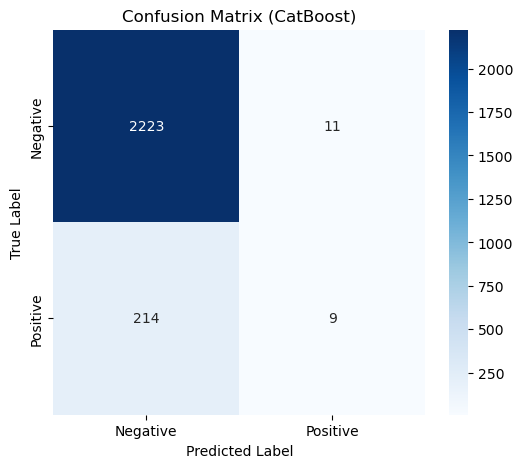

In [112]:
model, results = train_and_evaluate(X_train[new_500], y_train, X_test[new_500], y_test, model_type="CatBoost")

Training Time: 0.7127 seconds
Prediction Time: 0.0172 seconds
HistGB metrics:
	ROC_AUC: 0.7746805087706434
	Accuracy: 0.9067969067969068
	Precision: 0.27450980392156865
	Recall: 0.06796116504854369
	F1-Score: 0.10894941634241245
	Confusion Matrix: [[2214   37]
 [ 192   14]]


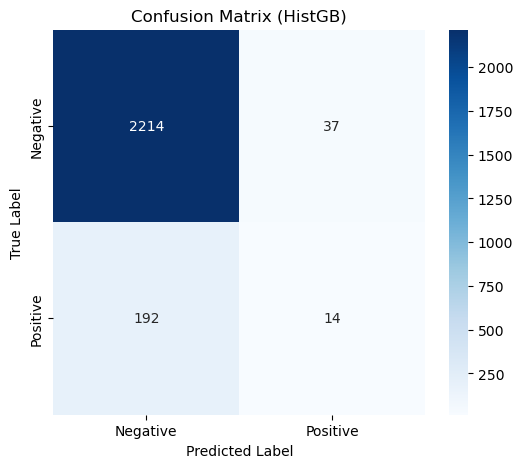

In [72]:
model, results = train_and_evaluate(X_200_train, y_train, X_200_test, y_test, model_type="HistGB")

Training Time: 0.5925 seconds
Prediction Time: 0.0154 seconds
HistGB metrics:
	ROC_AUC: 0.7749155715043585
	Accuracy: 0.9055759055759056
	Precision: 0.2903225806451613
	Recall: 0.08737864077669903
	F1-Score: 0.13432835820895522
	Confusion Matrix: [[2207   44]
 [ 188   18]]


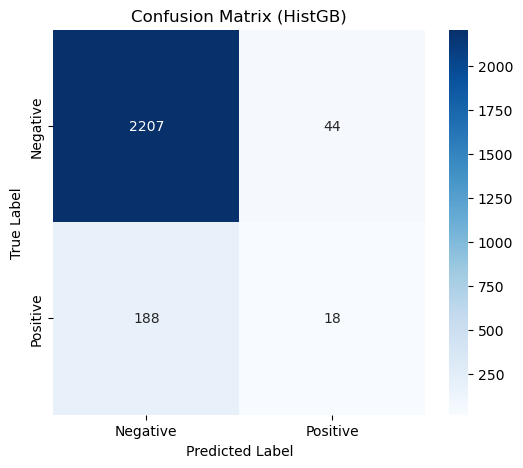

In [73]:
# with updated ftrs selection to limit categories

model, results = train_and_evaluate(X_train[new_200], y_train, X_test[new_200], y_test, model_type="HistGB")

In [74]:
# model, results = train_and_evaluate(X_100_train, y_train, X_100_validation, y_validation, model_type="LightGBM")

##### HistGB Output #####
Training Time: 0.5451 seconds
Prediction Time: 0.0152 seconds
HistGB metrics:
	ROC_AUC: 0.7874767978824098
	Accuracy: 0.901912901912902
	Precision: 0.3944954128440367
	Recall: 0.19724770642201836
	F1-Score: 0.26299694189602446
	Confusion Matrix: [[2173   66]
 [ 175   43]]


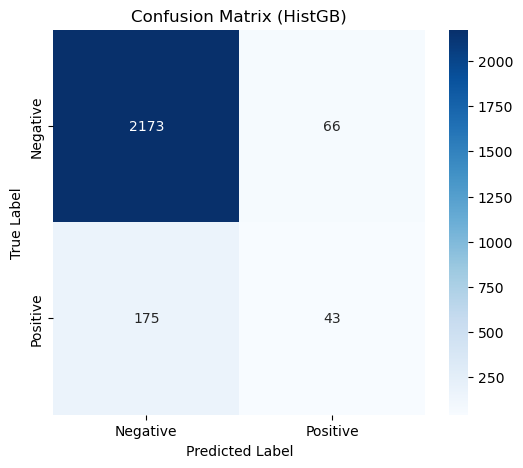

##### CatBoost Output #####
Training Time: 4.7473 seconds
Prediction Time: 0.0114 seconds
CatBoost metrics:
	ROC_AUC: 0.8034365767810826
	Accuracy: 0.9063899063899064
	Precision: 0.4268292682926829
	Recall: 0.16055045871559634
	F1-Score: 0.23333333333333334
	Confusion Matrix: [[2192   47]
 [ 183   35]]


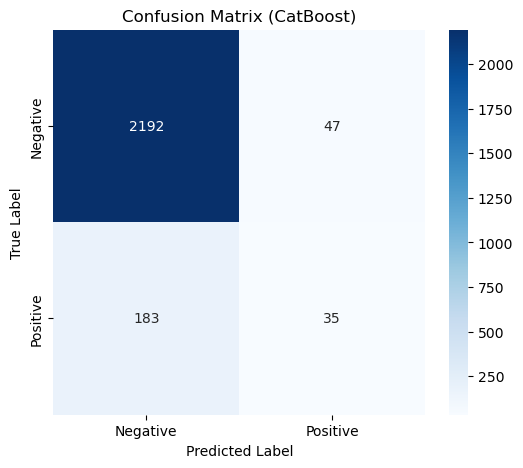

##### LightGBM Output #####
[LightGBM] [Info] Number of positive: 1181, number of negative: 4035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21575
[LightGBM] [Info] Number of data points in the train set: 5216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226419 -> initscore=-1.228645
[LightGBM] [Info] Start training from score -1.228645
Training Time: 0.3150 seconds
Prediction Time: 0.0103 seconds
LightGBM metrics:
	ROC_AUC: 0.7883577612875997
	Accuracy: 0.9023199023199023
	Precision: 0.39622641509433965
	Recall: 0.1926605504587156
	F1-Score: 0.25925925925925924
	Confusion Matrix: [[2175   64]
 [ 176   42]]


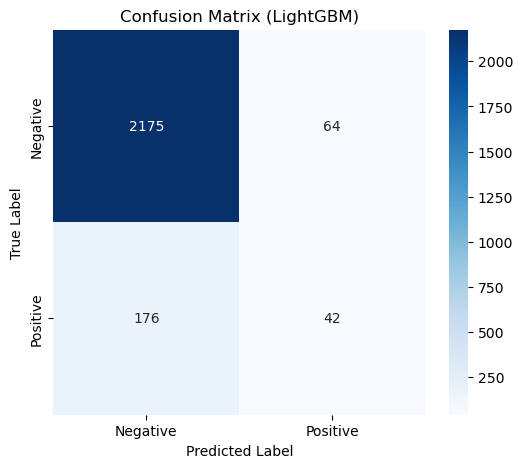

##### XGBoost Output #####


/home/akar/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:40:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 0.5293 seconds
Prediction Time: 0.0309 seconds
XGBoost metrics:
	ROC_AUC: 0.7631908904286399
	Accuracy: 0.9035409035409036
	Precision: 0.4144144144144144
	Recall: 0.21100917431192662
	F1-Score: 0.2796352583586626
	Confusion Matrix: [[2174   65]
 [ 172   46]]


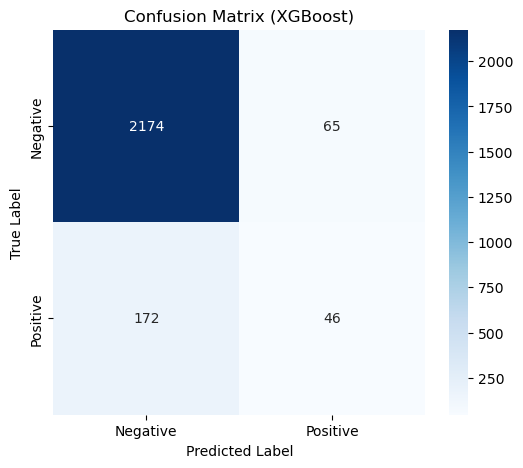

##### LogisticRegression Output #####
Training Time: 0.9768 seconds
Prediction Time: 0.2019 seconds
LogisticRegression metrics:
	ROC_AUC: 0.7468193123568435
	Accuracy: 0.8677248677248677
	Precision: 0.3174061433447099
	Recall: 0.42660550458715596
	F1-Score: 0.3639921722113503
	Confusion Matrix: [[2039  200]
 [ 125   93]]


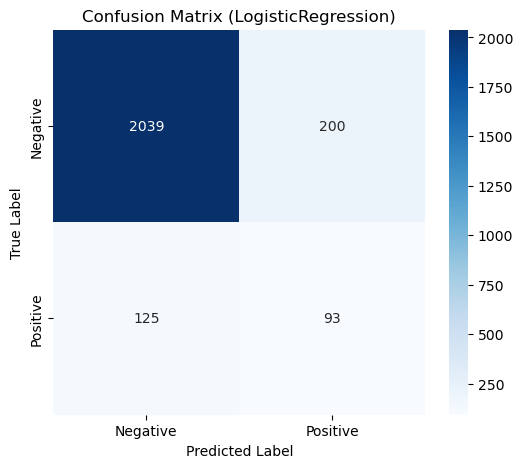

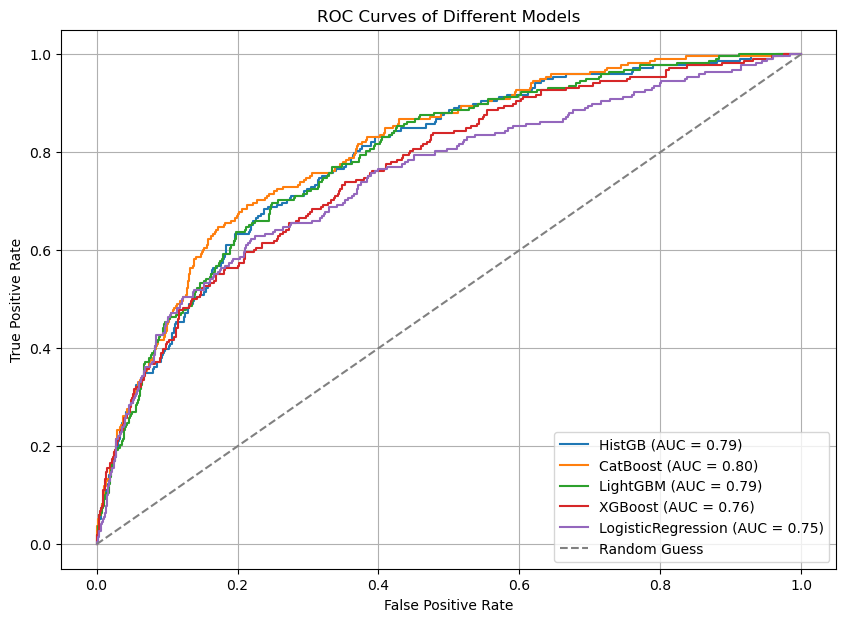

In [58]:
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
eval_data = {}
roc_data = {}

X_test_eval = X_test[top_100]

for model_type in model_types:
    print(f'##### {model_type} Output #####')
    model, results = train_and_evaluate(X_train[top_100], y_train, X_test_eval, y_test, model_type)
    del results['Confusion Matrix']
    eval_data[model_type] = results
    
    # Get ROC Curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_eval)[:, 1]
    else:
        y_prob = model.decision_function(X_test_eval) if hasattr(model, "decision_function") else model.predict(X_test_eval)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    roc_data[model_type] = (fpr, tpr, roc_auc)

eval_data = pd.DataFrame(eval_data)

# Plot all ROC curves at once
plt.figure(figsize=(10, 7))
for model_type, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{model_type} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Different Models')
plt.legend()
plt.grid()

filename = '../../q2_result/roc_auc_cs_models.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


### Hyper Parameter Tuning (Catboost, LightGBM, and HistGB)

In [99]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
import numpy as np


In [100]:
def tune_model(X, y, model_type="lightgbm", task="classification", n_iter=50, cv=5, scoring=None, random_state=42):
    """
    Perform hyperparameter tuning using RandomizedSearchCV.
    
    Parameters:
        X (pd.DataFrame or np.array): Feature matrix.
        y (pd.Series or np.array): Target variable.
        model_type (str): "catboost", "lightgbm", or "histgb".
        task (str): "classification" or "regression".
        n_iter (int): Number of parameter combinations to try.
        cv (int): Number of cross-validation folds.
        scoring (str or None): Scoring metric for RandomizedSearchCV.
        random_state (int): Random seed for reproducibility.

    Returns:
        best_model: Best fitted model after tuning.
        best_params: Best hyperparameters.
    """

    # Define model-specific hyperparameter grids
    param_grid = {}

    if model_type == "catboost":
        model = CatBoostClassifier(verbose=0, random_seed=random_state) if task == "classification" else CatBoostRegressor(verbose=0, random_seed=random_state)
        param_grid = {
            "iterations": np.arange(100, 1000, 100),
            "depth": np.arange(4, 12, 1),
            "learning_rate": np.linspace(0.01, 0.3, 10),
            "l2_leaf_reg": np.logspace(-3, 2, 6),
            "border_count": [32, 64, 128],
        }

    elif model_type == "lightgbm":
        model = LGBMClassifier(random_state=random_state) if task == "classification" else LGBMRegressor(random_state=random_state)
        param_grid = {
            "num_leaves": np.arange(10, 150, 10),
            "learning_rate": np.linspace(0.01, 0.3, 10),
            "n_estimators": np.arange(50, 500, 50),
            "max_depth": np.arange(3, 12, 1),
            "min_child_samples": np.arange(5, 50, 5),
            "subsample": np.linspace(0.5, 1.0, 5),
            "colsample_bytree": np.linspace(0.5, 1.0, 5),
            "reg_alpha": np.logspace(-3, 1, 5),
            "reg_lambda": np.logspace(-3, 1, 5),
        }

    elif model_type == "histgb":
        model = HistGradientBoostingClassifier(random_state=random_state) if task == "classification" else HistGradientBoostingRegressor(random_state=random_state)
        param_grid = {
            "learning_rate": [0.1, 0.5, 1, 5],
            "max_iter": np.arange(50, 550, 100),
            "max_leaf_nodes": np.arange(10, 50, 10),
            "min_samples_leaf": np.arange(5, 50, 10),
            "l2_regularization": np.logspace(-3, 1, 5),
            "max_bins": [32, 64, 128, 255],
        }

    else:
        raise ValueError("Invalid model_type. Choose from 'catboost', 'lightgbm', or 'histgb'.")

    # Perform Randomized Search
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(X, y)

    # Return the best model and best parameters
    return random_search.best_estimator_, random_search.best_params_


In [101]:
best_model, best_params = tune_model(X_500_validation, y_validation, model_type="catboost", task="classification", n_iter=10, cv=3, scoring="roc_auc")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [102]:
best_params

{'learning_rate': 0.042222222222222223,
 'l2_leaf_reg': 1.0,
 'iterations': 600,
 'depth': 5,
 'border_count': 64}

Training Time: 3.7989 seconds
Prediction Time: 0.0260 seconds
CatBoost metrics:
	ROC_AUC: 0.771944791261025
	Accuracy: 0.9067969067969068
	Precision: 0.4117647058823529
	Recall: 0.06278026905829596
	F1-Score: 0.10894941634241245
	Confusion Matrix: [[2214   20]
 [ 209   14]]


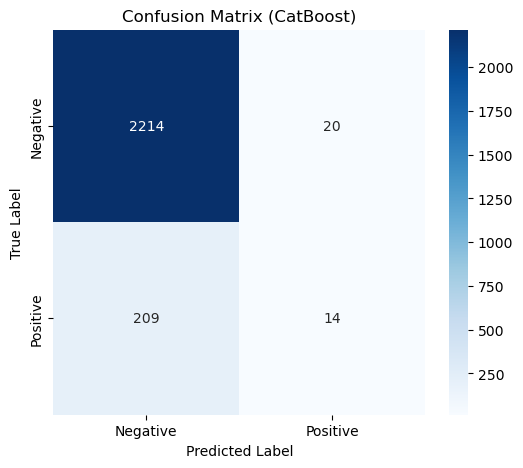

In [103]:
model, results = train_and_evaluate(X_500_train, y_train, X_500_test, y_test, model_type="CatBoost", model=best_model)

In [77]:
best_model, best_params = tune_model(X_validation[new_100], y_validation, model_type="histgb", task="classification", n_iter=30, cv=3, scoring="roc_auc")


Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [78]:
best_params

{'min_samples_leaf': 15,
 'max_leaf_nodes': 30,
 'max_iter': 450,
 'max_bins': 255,
 'learning_rate': 0.1,
 'l2_regularization': 1.0}

Training Time: 2.6808 seconds
Prediction Time: 0.0675 seconds
HistGB metrics:
	ROC_AUC: 0.7722651852682518
	Accuracy: 0.9015059015059015
	Precision: 0.3163265306122449
	Recall: 0.15048543689320387
	F1-Score: 0.20394736842105263
	Confusion Matrix: [[2184   67]
 [ 175   31]]


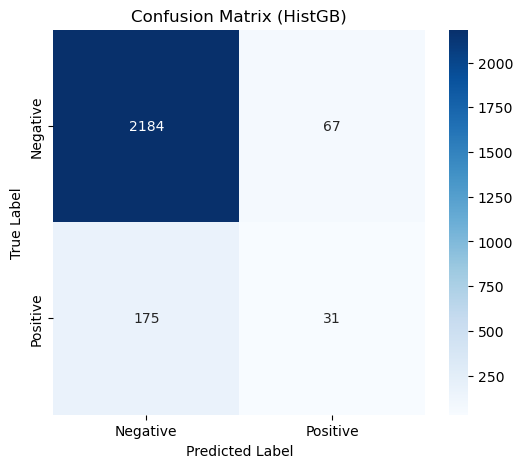

In [79]:
model, results = train_and_evaluate(X_train[new_100], y_train, X_test[new_100], y_test, model_type="HistGB", model=best_model)

In [80]:
best_model, best_params = tune_model(X_train[new_100], y_train, model_type="lightgbm", task="classification", n_iter=30, cv=3, scoring="roc_auc")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 676, number of negative: 2684
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18954
[LightGBM] [Info] Number of data points in the train set: 3360, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201190 -> initscore=-1.378870
[LightGBM] [Info] Start training from score -1.378870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

In [81]:
best_params

{'subsample': 0.5,
 'reg_lambda': 0.1,
 'reg_alpha': 0.001,
 'num_leaves': 140,
 'n_estimators': 200,
 'min_child_samples': 15,
 'max_depth': 9,
 'learning_rate': 0.20333333333333334,
 'colsample_bytree': 0.625}

[LightGBM] [Info] Number of positive: 1014, number of negative: 4026
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20194
[LightGBM] [Info] Number of data points in the train set: 5040, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201190 -> initscore=-1.378870
[LightGBM] [Info] Start training from score -1.378870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

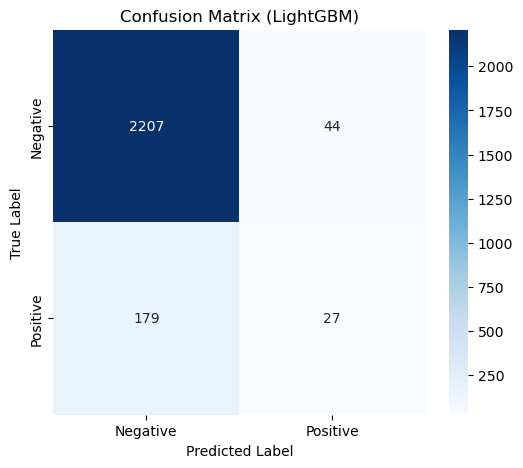

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [82]:
model, results = train_and_evaluate(X_train[new_100], y_train, X_test[new_100], y_test, model_type="LightGBM", model=best_model)

In [ ]:
2+2

In [ ]:
best_model

In [ ]:
best_params

In [ ]:
top_200[10:]

# Extra Visualization

In [103]:
def plot_binned_bad_rate(df, feature, target, bins=10, method='quantile'):
    """
    Plots the binned bad rate for a given feature.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
        feature (str): The numeric column to be binned.
        target (str): The binary target column (1 = bad, 0 = good).
        bins (int or list): Number of bins (if int) or custom bin edges (if list).
        method (str): 'quantile' for equal-sized bins, 'uniform' for equal-width bins.
    
    Returns:
        None
    """
    df = df[[feature, target]].dropna()
    
    # Binning
    if method == 'quantile':
        df['bin'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    else:  # 'uniform' binning
        df['bin'] = pd.cut(df[feature], bins=bins)
    
    # Compute bad rate
    bad_rate = df.groupby('bin')[target].mean()
    
    # Plot
    plt.figure(figsize=(10, 6))
    bad_rate.plot(kind='bar', color='skyblue', edgecolor='black')
    
    plt.xlabel(f'Binned {feature}')
    plt.ylabel('Bad Rate')
    plt.title(f'Binned Bad Rate Plot for {feature}')


    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()


/tmp/ipykernel_400/1866377898.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bad_rate = df.groupby('bin')[target].mean()


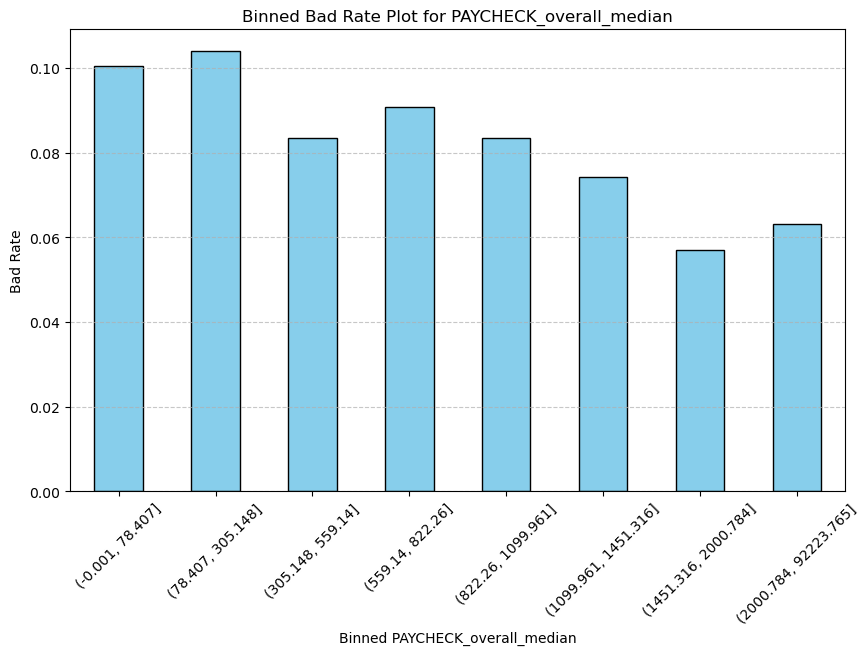

In [104]:
plot_binned_bad_rate(data, feature='PAYCHECK_overall_median', target='DQ_TARGET')

In [ ]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

def plot_partial_dependence(model, X, feature, feature_names=None):
    """
    Plots the Partial Dependence Plot (PDP) for a given feature.
    
    Parameters:
        model: Trained machine learning model.
        X (pd.DataFrame or np.array): Feature dataset.
        feature (int or str): Index (if array) or name (if DataFrame) of the feature to plot.
        feature_names (list, optional): List of feature names if X is a NumPy array.
    
    Returns:
        None
    """
    if isinstance(X, np.ndarray) and feature_names is None:
        raise ValueError("If X is a NumPy array, feature_names must be provided.")
    
    features = [feature] if isinstance(feature, int) else [X.columns.get_loc(feature)]
    
    # Compute Partial Dependence
    pd_result = partial_dependence(model, X, features)
    
    # Extract values
    feature_values = pd_result['values'][0]
    pd_values = pd_result['average'][0]
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(feature_values, pd_values, marker='o', linestyle='-', color='blue')
    plt.xlabel(feature if isinstance(feature, str) else feature_names[feature])
    plt.ylabel("Partial Dependence")
    plt.title(f"Partial Dependence Plot for {feature}")
    plt.grid(True)
    plt.show()

In [ ]:
model, results = train_and_evaluate(X_200_train, y_train, X_200_test, y_test, model_type="HistGB")

In [ ]:
# plot_partial_dependence(model, pd.concat([X_200_train, X_200_validation, X_200_test], axis=0), "balance_delta_overall", feature_names=None)
# balance_mean
plot_partial_dependence(model, X_200_test, "PAYCHECK_overall_median", feature_names=None)

essentially illustrates what values of balance_mean are associated with predicting deliquency (1 or 0)

In [ ]:
plot_partial_dependence(model, X_200_test, "GAMBLING_last_30_days_percent", feature_names=None)

In [ ]:
plot_partial_dependence(model, X_200_test, "SELF_TRANSFER_overall_median", feature_names=None)

In [ ]:
for top_200_i in top_200[:10]:
    plot_partial_dependence(model, X_200_test, top_200_i, feature_names=None)

### Binned Bad Rates (Heatmap)

Training Time: 31.8929 seconds
Prediction Time: 0.0617 seconds
CatBoost metrics:
	ROC_AUC: 0.8088518036027134
	Accuracy: 0.9124949124949125
	Precision: 0.37142857142857144
	Recall: 0.1319796954314721
	F1-Score: 0.1947565543071161
	Confusion Matrix: [[2216   44]
 [ 171   26]]


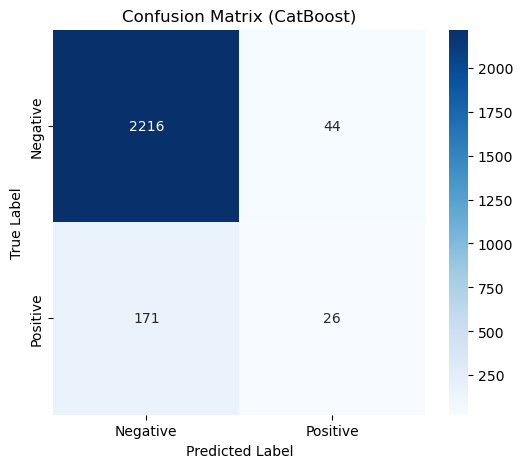

In [65]:
model, results = train_and_evaluate(X_train[top_1000], y_train, X_test[top_1000], y_test, model_type="CatBoost")

In [142]:
model_proba = proba(X_test[top_1000], y_test, model)

bbr_hmDF = data_orig.loc[X_test.index][['balance_mean', 'credit_score']]
bbr_hmDF['probas'] = model_proba
bbr_hmDF.head()

,balance_mean,credit_score,probas
8395,354.5621,626.0000,0.1069
1082,"4,575.9526",779.0000,0.0078
4594,72.6498,592.0000,0.6039
4806,"2,085.9397",532.0000,0.3325
4824,"-2,800.4540",641.0000,0.0389


In [143]:
'credit_score' in continuous_cols

True

In [147]:
balance_bins

array([ -71987.185     ,  508065.02066158, 1088117.22632315])

/tmp/ipykernel_400/3323072775.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bbr_hmDF.groupby(['balance_bin', 'credit_score_bin'])['probas']


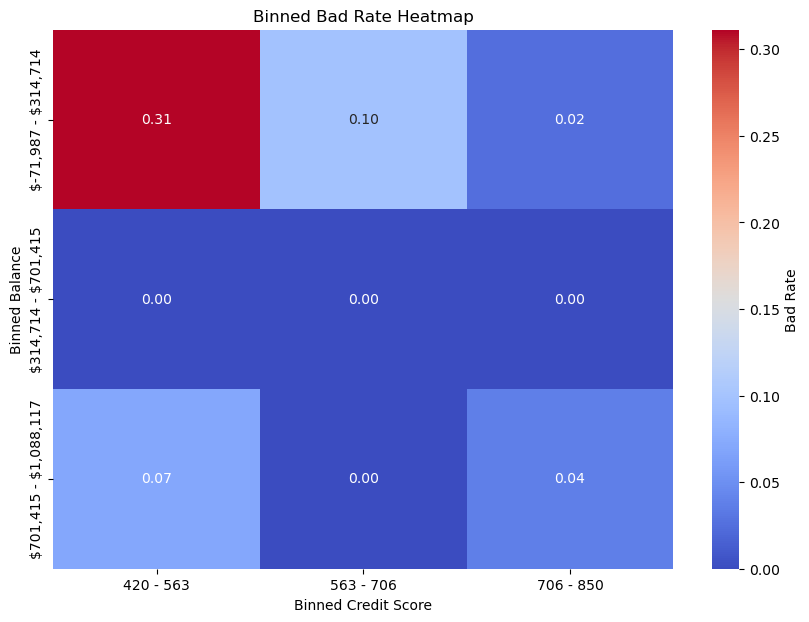

In [166]:
balance_bins = np.linspace(bbr_hmDF['balance_mean'].min(), bbr_hmDF['balance_mean'].max(), 4)  # 10 balance bins
credit_score_bins = np.linspace(bbr_hmDF['credit_score'].min(), bbr_hmDF['credit_score'].max(), 4)  # 10 credit score bins

balance_labels = [f"\${int(balance_bins[i]):,} - \${int(balance_bins[i+1]):,}" for i in range(len(balance_bins) - 1)]
credit_score_labels = [f"{int(credit_score_bins[i])} - {int(credit_score_bins[i+1])}" for i in range(len(credit_score_bins) - 1)]

bbr_hmDF['balance_bin'] = pd.cut(bbr_hmDF['balance_mean'], bins=balance_bins, labels=balance_labels, ordered=True, include_lowest=True)
bbr_hmDF['credit_score_bin'] = pd.cut(bbr_hmDF['credit_score'], bins=credit_score_bins, labels=credit_score_labels, ordered=True, include_lowest=True)

all_bins = pd.MultiIndex.from_product([balance_labels, credit_score_labels], names=["balance_bin", "credit_score_bin"])

hm_pivot = (
    bbr_hmDF.groupby(['balance_bin', 'credit_score_bin'])['probas']
    .mean()
    .reindex(all_bins, fill_value=0)  # Force missing combinations to show
    .unstack()
)
hm_pivot.fillna(0, inplace=True)



plt.figure(figsize=(10, 7))
sns.heatmap(hm_pivot, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=hm_pivot.max().max(), cbar_kws={'label': 'Bad Rate'})

plt.xlabel("Binned Credit Score")
plt.ylabel("Binned Balance")
plt.title("Binned Bad Rate Heatmap")
filename = '../../q2_result/bbr_csore_bal_3.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')


plt.show()


### Feature Selection (Embedded Method)

In [ ]:
rf = RandomForestClassifier()
# rf.fit(X_train, y_train)

rf = RandomForestClassifier(
    n_estimators=300,        # More trees for stability (100-500 is a good range)
    max_depth=15,            # Limit depth to avoid overfitting (None allows full growth)
    min_samples_split=5,      # Require at least 5 samples to split a node (prevents overfitting)
    min_samples_leaf=2,       # Minimum of 2 samples per leaf for better generalization
    max_features='sqrt',      # Use sqrt(features) at each split (good balance of performance)
    bootstrap=True,           # Bootstrap sampling (default, helps with variance reduction)
    random_state=42,          # For reproducibility
    n_jobs=-1                 # Use all CPU cores for faster training
)

rf.fit(X_resampled, y_resampled)

In [ ]:
feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
importance_df['Importance_Abs'] = importance_df.Importance.apply(lambda x: abs(x))


# Sort by importance (descending order)
importance_df = importance_df.sort_values(by="Importance_Abs", ascending=False)
importance_df.head(10)

In [ ]:
top_100_ftrs = importance_df.Feature.values[:100]

X_100 = X_train[top_100_ftrs]
X_100_test = X_test[top_100_ftrs]

X_100.shape, y_train.shape

In [ ]:
X_100_train, X_100_validation, y_100_train, y_100_validation = train_test_split(X_100, y_train, test_size=0.25,)

In [ ]:
lr_100_train_metrics, lr_100_test_metrics = pipeline(X_100, y_train)

### More Models

Training Time: 8.6668 seconds
Prediction Time: 0.1608 seconds
HistGB metrics:
	ROC_AUC: 0.7420727811420397
	Accuracy: 0.9083333333333333
	Precision: 0.36065573770491804
	Recall: 0.08527131782945736
	F1-Score: 0.13793103448275862
	Confusion Matrix: [[2703   39]
 [ 236   22]]


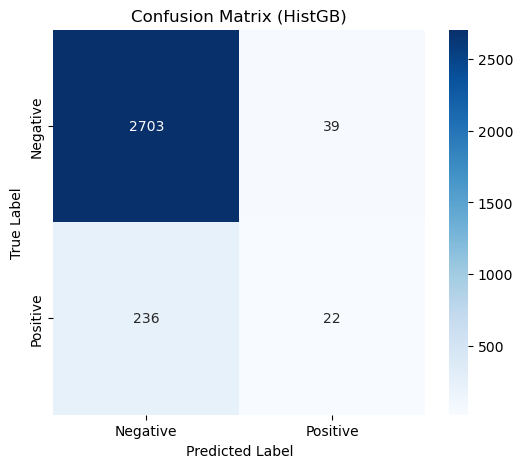

In [372]:
model, results = train_and_evaluate(X_resampled, y_resampled, X_test, y_test, model_type="HistGB")

Training Time: 0.5888 seconds
Prediction Time: 0.0194 seconds
HistGB metrics:
	ROC_AUC: 0.732802684624475
	Accuracy: 0.9043333333333333
	Precision: 0.32098765432098764
	Recall: 0.10077519379844961
	F1-Score: 0.15339233038348082
	Confusion Matrix: [[2687   55]
 [ 232   26]]


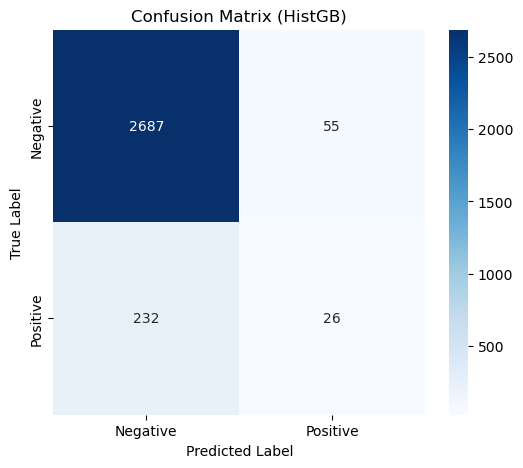

In [373]:
model, results = train_and_evaluate(X_100_train, y_100_train, X_100_test, y_test, model_type="HistGB")

[LightGBM] [Info] Number of positive: 862, number of negative: 3692
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16943
[LightGBM] [Info] Number of data points in the train set: 4554, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.189284 -> initscore=-1.454668
[LightGBM] [Info] Start training from score -1.454668
Training Time: 0.3272 seconds
Prediction Time: 0.0143 seconds
LightGBM metrics:
	ROC_AUC: 0.736575464070248
	Accuracy: 0.905
	Precision: 0.3291139240506329
	Recall: 0.10077519379844961
	F1-Score: 0.1543026706231454
	Confusion Matrix: [[2689   53]
 [ 232   26]]


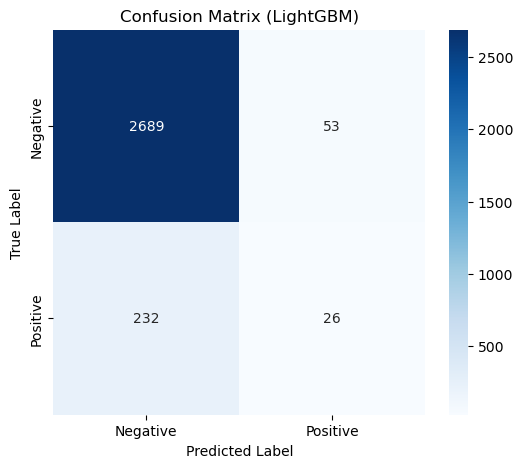

In [374]:
model, results = train_and_evaluate(X_100_train, y_100_train, X_100_test, y_test, model_type="LightGBM")